# Assignment 6

[3 points] Delelop language model, which generates texts from wikipedia.   
Use WikiText-2 dataset, also available in `torchtext.datasets`.  
Use `sentencepiece` or `tokenizers` library for text tokenization. Pay attention to vocab size, probably subword tokens are better.    
Your model should be autogressive RNN.  
[1 point] Plot train and validation loss depending on the number of iterations of gradient decent.  
[1 point] Try to use together (`sentencepiece` or `tokenizers`), `torchtext.datasets`, and `torchtext.data.BPTTIterator`  

<img src="images/lm.jpg" style="height:300px">

Text generation should be terminated when either max length is reached or terminal symbol is generated.  
Explore several inference techniques:
1. [1 point] Argmax
1. [1 point] Beamsearch
1. [1 point] Sampling from probabilty distribution with temperature
1. [1 point] Nucleus sampling
1. [1 point] Top-k sampling

For every method you should provide implemented code and generated examples. Each example must contain at least 10 words (not subword tokens).

Readings:
https://arxiv.org/abs/1904.09751

In [0]:
!pip install bpemb
import pandas as pd
from bpemb import BPEmb
import numpy as np
from sklearn.externals import joblib
import nltk
import gensim
import spacy
from tqdm import tqdm_notebook
from sklearn import metrics
import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.data import Field, LabelField, BPTTIterator
from torchtext import datasets
SEED = 42
np.random.seed(SEED)

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, target_vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True
                          )
        
        self.fc = nn.Linear(hidden_size * 2, target_vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        
        x = batch
        # x_lengths = [len(y) for y in x]
        batch_size = x.size(0)
        total_length = x.size(1)
        
        x = self.embedding(x)

        # x = nn.utils.rnn.pack_padded_sequence(x, x_lengths, batch_first=True)
            
        x, _ = self.rnn(x)
        
        # x, _ = nn.utils.rnn.pad_packed_sequence(x, total_length=total_length, batch_first=True)
        
        x = x.contiguous().view(batch_size * total_length, -1)
        x = self.fc(x)
        x = x.contiguous().view(batch_size , total_length, -1)
        return x.transpose(1,2)

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()

    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    all_losses = []
    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        pred = model(batch.text)
        loss = criterion(pred, batch.target)
        loss.backward()
        optimizer.step()

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss)
        all_losses.append(curr_loss)
        
    return running_loss, all_losses

def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    n_batches = len(iterator)
    all_losses = []
    with tt.no_grad():
        for batch in iterator:
            pred = model(batch.text)
            loss = criterion(pred, batch.target)
            epoch_loss += loss.data.item()
            all_losses.append(loss.data.item())

    return epoch_loss / n_batches, all_losses


def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()
    plot_valid_losses = []
    plot_train_losses = []
    for epoch in range(n_epochs):
        train_loss, train_losses = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss, valid_losses = _test_epoch(model, valid_iterator, criterion)
        plot_valid_losses.extend(valid_losses)
        plot_train_losses.extend(train_losses)
        valid_loss = valid_loss
        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history, plot_train_losses, plot_valid_losses

In [0]:
import torchtext
from torchtext import data

In [0]:
max_length = 30
bpemb_en = BPEmb(lang="en", dim=300, vs=100000)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
bpemb_en.encode("He is a silent presence in the darkness.")

['▁he', '▁is', '▁a', '▁silent', '▁presence', '▁in', '▁the', '▁darkness', '.']

In [0]:
device = tt.device('cuda' if tt.cuda.is_available() else 'cpu')

In [0]:
device

device(type='cuda')

In [0]:
TEXT = Field(
             tokenize=bpemb_en.encode, batch_first=True,
             lower=True, eos_token='<eos>', pad_token='<pad>', init_token = '<start>',
            )

In [0]:
TEXT.eos_token

'<eos>'

In [0]:
train, valid, test = datasets.WikiText2.splits(TEXT)

In [0]:
len(train), len(test)

(1, 1)

In [0]:
TEXT.build_vocab(train) # train, valid, test

In [0]:
len(TEXT.vocab.itos)

27629

In [0]:
TEXT.vocab.itos[:20]

['<unk>',
 '<pad>',
 '<start>',
 '<eos>',
 '▁the',
 '▁,',
 '▁',
 '▁.',
 '▁of',
 '<',
 '>',
 'unk',
 '▁and',
 '@',
 '▁in',
 '▁to',
 '▁a',
 '▁=',
 '▁"',
 '▁0000']

In [0]:
batch_size = 32
tt.cuda.empty_cache()
train_iterator, valid_iterator, test_iterator = BPTTIterator.splits(
    (train, valid, test), device=device,
    batch_sizes=(batch_size, batch_size, batch_size),
    bptt_len=max_length, shuffle = True,                     
    repeat=False)

In [0]:
train_iterator

In [0]:
for batch in train_iterator:
    print(batch)
    print(batch.text.shape)
    print(batch.text[:, :3])
    print(batch.target[:, :3])
    break


[torchtext.data.batch.Batch of size 32]
	[.text]:[torch.cuda.LongTensor of size 30x32 (GPU 0)]
	[.target]:[torch.cuda.LongTensor of size 30x32 (GPU 0)]
torch.Size([30, 32])
tensor([[    3,    17,     9],
        [   17,    17,    11],
        [ 3799,    17,    10],
        [ 3205,     3,   867],
        [ 3820,     3,  1210],
        [  864,     4,  2688],
        [   17,  2349,     5],
        [    3,  5120,     6],
        [    3,     4,     9],
        [13980,  3875,    11],
        [18326,  1459,    10],
        [   98,  1665,    12],
        [ 3799,     4,    16],
        [ 3205,   137,   128],
        [   28, 10148,     8],
        [   59,    67,  2750],
        [    6,  1195,     5],
        [    9,  4873,  1991],
        [   11,    14,   196],
        [   10,  2544,    16],
        [ 3820,    22,  1515],
        [   33,    24,  2646],
        [  762,   278, 12504],
        [   59,     7,  8465],
        [    6,  5433,     4],
        [27627,  3898,   281],
        [  296, 1526

In [0]:
model = MyModel(vocab_size=len(TEXT.vocab.itos),
                target_vocab_size=len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )
model = model.cuda()

In [0]:
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.CrossEntropyLoss(ignore_index=1)
criterion = criterion.cuda()

In [0]:
history, plot_train_losses, plot_valid_losses = nn_train(model, train_iterator, valid_iterator, criterion, optimizer, scheduler=scheduler, 
        n_epochs=10, early_stopping=2) #n_epochs=10


validation loss 4.79276



validation loss 4.69393



validation loss 4.67411


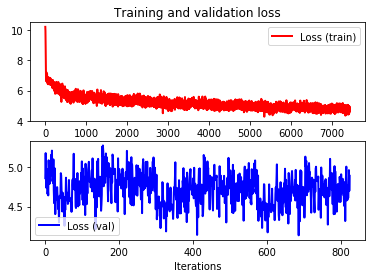

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
def loss_plot(train_loss, valid_loss):
    plt.figure()
    plt.subplot(211)

    plt.title('Training and validation loss')
    plt.plot(train_loss, color='red', linewidth=2, label = 'Loss (train)')
    plt.legend()

    plt.subplot(212)
    plt.xlabel('Iterations')
    plt.plot(valid_loss, color='blue', linewidth=2, label = 'Loss (val)')
    plt.legend()
    plt.show()

loss_plot(plot_train_losses, plot_valid_losses)

In [0]:
def reverse(self, batch):
    if not self.batch_first:
        batch = batch.t()
    with tt.cuda.device_of(batch):
        batch = batch.tolist()
    batch = [[self.vocab.itos[ind] for ind in ex] for ex in batch]  # denumericalize

    def trim(s, t):
        sentence = []
        for w in s:
            if w == t:
                break
            sentence.append(w)
        return sentence

    batch = [trim(ex, self.eos_token) for ex in batch]  # trim past frst eos

    def filter_special(tok):
        return tok not in (self.init_token, self.pad_token)

    batch = [filter(filter_special, ex) for ex in batch]
    return [' '.join(ex) for ex in batch]

In [0]:
example_batch = next(iter(train_iterator))

In [0]:
pred = model(example_batch.text)
print(pred[:, :, :2], type(pred), pred.shape)

tensor([[[-12.7919, -13.8441],
         [-12.7410, -13.8662],
         [-12.9713, -14.1411],
         ...,
         [-18.1651, -20.3512],
         [ -8.7183, -11.1089],
         [-16.2525, -17.4205]],

        [[-13.2695, -13.8822],
         [-13.3072, -13.9046],
         [-13.5976, -14.1797],
         ...,
         [-18.7182, -20.4294],
         [-10.2379, -11.1771],
         [-16.8915, -17.6280]],

        [[-14.5634, -14.1332],
         [-14.5304, -14.1559],
         [-14.8646, -14.4544],
         ...,
         [-11.1838, -20.5684],
         [ -6.1162, -11.4289],
         [ -8.4940, -17.8019]],

        ...,

        [[-10.3270, -17.4844],
         [-10.3510, -17.4292],
         [-10.5043, -17.8581],
         ...,
         [-13.3636,  -0.9593],
         [ -7.9028,  -0.1294],
         [-10.7302,   2.4186]],

        [[-12.5140, -20.0813],
         [-12.5554, -20.1059],
         [-12.7486, -20.6006],
         ...,
         [-14.3074, -17.9938],
         [ -8.1531, -11.7194],
         

In [0]:
pred = tt.softmax(pred, dim=1)
pred.shape

torch.Size([30, 27629, 32])

In [0]:
pred = tt.argmax(pred, dim=1)
pred.shape

torch.Size([30, 32])

In [0]:
for batch in test_iterator:
    pred = model(batch.text)
    pred = tt.softmax(pred, dim=1)
    pred = tt.argmax(pred, dim=1)
    pred_tags = reverse(TEXT, pred)
    true_tags = reverse(TEXT, batch.target)
    true_text = reverse(TEXT, batch.text)
    
    for i in range(len(pred_tags)):
        print(i)
        print('text: ', true_text[i])
        print('pred tags: ', pred_tags[i])
        print('true tags: ', true_tags[i])
        print()
        
    break

0
text:  <eos> ▁increase ▁a > > ▁more < ▁smooth ▁) unk ▁via ▁' ▁) ▁0000 ▁' ▁his ▁00 ▁) ▁first ▁called ▁. ▁finland > ▁. ▁church ▁to ▁sets ▁of ▁concrete ▁of ▁0 >
pred tags:  <eos> ▁in ▁ ▁, ▁, ▁than unk ▁, ▁, > ▁the s ▁, ▁, s ▁first ▁, ▁, ▁season ▁the <eos> ▁, ▁ <eos> ▁, ▁the ▁of ▁the ▁, ▁the ▁ ▁
true tags:  ▁= ▁in ▁pioneering ▁, ▁records ▁likely unk ▁skull ▁, > ▁the ▁" ▁south ▁ s ▁return ▁pm ▁and ▁head ▁stevens ▁by ▁followed ▁, ▁000 ▁and ▁drive ▁stone ▁the ▁, ▁the ▁' ▁was

1
text:  ▁= ▁in ▁pioneering ▁, ▁records ▁likely unk ▁skull ▁, > ▁the ▁" ▁south ▁ s ▁return ▁pm ▁and ▁head ▁stevens ▁by ▁followed ▁, ▁000 ▁and ▁drive ▁stone ▁the ▁, ▁the ▁' ▁was
pred tags:  ▁= ▁the ▁the ▁and ▁, ▁to > ▁, ▁and ▁ ▁ ▁. ▁korean < ▁ ▁to ▁, ▁the ▁of ▁' ▁the ▁by ▁and th ▁the ▁in ▁, ▁ ▁and ▁ s ▁a
true tags:  ▁robert ▁facebook ▁television ▁jr ▁, ▁to > ▁surface ▁ ▁by ▁uss ▁. ▁of @ ▁agent ▁match ▁, ▁the ▁in ▁to ▁the ▁on ▁on ▁– ▁the ▁the ▁ ▁largest ▁steel ▁fact s ▁assassinated

2
text:  ▁robert ▁facebook ▁television

In [0]:
pred = model(example_batch.text)
pred = tt.softmax(pred, dim=1)
pred = tt.argmax(pred, dim=1)
pred.shape

torch.Size([30, 32])

In [0]:
reverse(TEXT, pred)

['<eos> ▁= unk > ▁, ▁ < ▁to > ▁the ▁ ▁, ▁0 ▁ ▁ ▁with ▁, ▁to ▁ ▁ ▁= ▁a ▁, ▁= > ▁the ▁the ▁the ▁released ▁the ▁, ▁',
 '▁= ▁= > ▁ ▁the ▁. unk ▁, ▁, ▁, ▁of ▁of ▁ ▁, ▁was ▁ ▁and ▁the ▁, ▁, ▁= ▁ ▁of ▁ ▁ ▁, ▁and ▁ ▁by ▁ ▁the ▁in',
 "ria ▁= ▁, ▁, ▁' <eos> > ▁of < <eos> ▁a ▁the < ▁the ▁, ▁' ▁, ▁were ▁and ▁= ▁= < ▁ ▁ ▁the < ▁was ▁, ▁the ▁than hed ▁the",
 "▁of <eos> ▁, ▁the ▁and ▁the ▁ ▁the - ▁ ▁ ▁in - ▁ <eos> ▁on ▁out ▁from ▁that ▁= <eos> unk ▁to ▁was apo unk ▁released ▁a ▁' ▁the r ▁",
 '▁ii <eos> ▁ii ▁ ▁with ▁, ▁the ▁ @ ▁to ▁ <eos> @ ▁of ▁the ▁the ▁for ▁the ▁the ▁= <eos> > ▁a ▁= ▁was > ▁the ▁be ▁, ▁of uli ▁,',
 "▁, ▁ ▁ ▁' ▁the ▁and ▁ ▁of - ▁, ▁. ▁. - ▁the ▁to ▁ ▁from ▁, ▁ <eos> < ▁, ▁reviews <eos> ▁, ▁ ▁a ▁the ▁and ▁the ▁, ▁of",
 '▁= ▁, ▁and <eos> ▁, ▁ ▁, ▁the < ▁and <eos> ▁ ▁ ▁of ▁the ▁, ▁the <eos> ▁, <eos> unk nell ▁of <eos> ▁the ▁that ▁. ▁and ▁as ▁on ▁, ▁the',
 '<eos> ▁the < ▁ ▁as ▁, ▁and ▁ unk ▁ ▁, < < ▁, ▁ <eos> ▁ ▁the ▁of ▁the > ▁ ▁and ▁season ▁. ▁the ▁to ▁the ▁the ▁, <eos> ▁to',
 '<eos> 

In [0]:
temperature = 0.2 # try from 0 to 1
pred = model(example_batch.text)
pred = tt.softmax(pred.div(temperature), dim=1)
pred = tt.argmax(pred, dim=1)
pred.shape

torch.Size([30, 32])

In [0]:
new_sequence = tt.cat([example_batch.text, pred[:1, :]], 0)
new_sequence.shape

torch.Size([31, 32])

In [0]:
pred = model(new_sequence)
pred = tt.softmax(pred.div(temperature), dim=1)
pred = tt.argmax(pred, dim=1)
pred.shape

torch.Size([31, 32])

In [0]:
new_sequence = example_batch.text
with tt.no_grad():  # no tracking history
    for i in range(20):
        pred = model(new_sequence)
        pred = tt.softmax(pred.div(temperature), dim=1)
        pred = tt.argmax(pred, dim=1)
        new_sequence = tt.cat([new_sequence, pred[:1, :]], 0)
print(new_sequence.shape)

torch.Size([50, 32])
